# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.734904,False,-0.019114
1,-0.309628,False,-1.022775
2,-0.541264,False,-1.309087
3,-0.037184,False,1.229715
4,-0.923806,True,4.374885
...,...,...,...
995,0.543022,True,4.954280
996,0.554416,True,5.238026
997,1.684447,True,5.829171
998,-0.152655,True,5.972417


<Axes: xlabel='v0'>

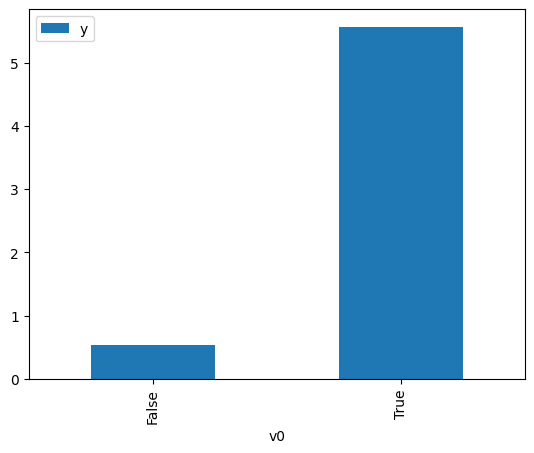

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

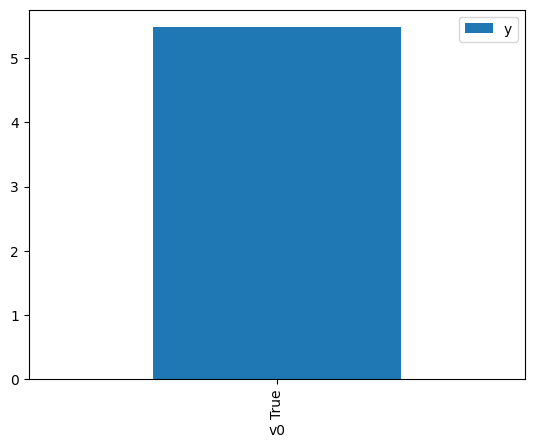

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.247882,False,0.982417,0.430022,2.325465
1,-0.039228,False,0.256933,0.500526,1.997899
2,0.083001,False,0.249216,0.470349,2.126082
3,0.553664,False,0.480409,0.357992,2.793358
4,0.589304,False,0.592713,0.349934,2.857679
...,...,...,...,...,...
995,0.879313,False,1.105798,0.287807,3.474554
996,0.666595,False,0.688326,0.332756,3.005203
997,1.301464,False,2.065647,0.210246,4.756328
998,1.290057,False,1.489593,0.212125,4.714202


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.219700,True,2.449806,0.454988,2.197860
1,2.428243,True,7.835641,0.919642,1.087380
2,-0.517883,True,2.831816,0.383350,2.608579
3,0.803413,True,6.971343,0.696570,1.435606
4,2.132851,True,7.746414,0.895242,1.117017
...,...,...,...,...,...
995,0.530614,True,5.629971,0.636753,1.570467
996,0.107537,True,5.797297,0.535690,1.866752
997,1.358418,True,5.977250,0.798951,1.251641
998,0.560684,True,5.955321,0.643602,1.553756


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                          1.074e+04
Date:                Fri, 14 Jun 2024   Prob (F-statistic):                        0.00
Time:                        15:03:26   Log-Likelihood:                         -1435.2
No. Observations:                1000   AIC:                                      2874.
Df Residuals:                     998   BIC:                                      2884.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1700      0.035     32.973      0.000       1.100       1.240
x2             4.8881      0.051     96.412      0.000       4.789       4.988
==============================================================================
Omnibus:                        8.331   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.258
Skew:                           0.214   Prob(JB):                       0.0161
Kurtosis:                       3.119   Cond. No.                         2.16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""